In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from matplotlib import rcParams
config = {
    "font.family":'Times New Roman',
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
}
rcParams.update(config)

# silence the warning note
import warnings
warnings.filterwarnings("ignore")

from findpoint import findpoint
import ModelEvaLib as me

In [2]:
chemfile = xr.open_dataset('F:/Data/case_anqing/compressed_chem.nc')

O3 = chemfile.O3
NO2 = chemfile.NO2

lat = chemfile.latitude
lon = chemfile.longitude

In [11]:
com = O3 + NO2
com

<xarray.DataArray (time: 672, level: 38, y: 138, x: 135)>
array([[[[ 132.53064 ,  137.61652 ,  143.88301 , ...,   56.68327 ,
            66.561554,   71.43984 ],
         [ 132.7084  ,  138.08153 ,  145.83823 , ...,   63.74136 ,
            70.38196 ,   73.53365 ],
         [ 137.1559  ,  134.7194  ,  139.56853 , ...,   72.22721 ,
            72.89433 ,   70.70511 ],
         ...,
         [  47.20536 ,   49.494637,   48.88681 , ...,   84.124886,
            80.9361  ,   83.9311  ],
         [  48.144398,   49.586514,   48.36955 , ...,   88.25925 ,
            79.28626 ,   82.083145],
         [  49.117714,   47.72337 ,   47.749126, ...,   87.20846 ,
            81.46964 ,   82.654434]],

        [[ 138.10834 ,  153.76772 ,  157.88817 , ...,   67.660126,
            70.218895,   72.230415],
         [ 139.88374 ,  145.18298 ,  158.21536 , ...,   73.557175,
            71.40868 ,   73.42316 ],
         [ 152.31848 ,  140.22763 ,  147.35492 , ...,   86.767265,
            77.7585  ,   72.19371 ],
...
         [ 515.7716  ,  516.06854 ,  517.32153 , ...,  665.51526 ,
           664.84784 ,  665.7999  ],
         [ 502.71353 ,  506.86383 ,  509.0458  , ...,  663.9296  ,
           665.2252  ,  665.2235  ],
         [ 501.8226  ,  502.58835 ,  504.23093 , ...,  663.6147  ,
           665.9317  ,  665.7078  ]],

        [[1659.6201  , 1666.6884  , 1643.6206  , ..., 1457.5245  ,
          1467.1803  , 1475.3949  ],
         [1617.168   , 1623.3765  , 1613.1289  , ..., 1450.6064  ,
          1455.8369  , 1461.1992  ],
         [1614.003   , 1614.9335  , 1608.2533  , ..., 1443.7368  ,
          1448.8317  , 1453.7383  ],
         ...,
         [1472.1447  , 1472.2703  , 1472.3976  , ..., 1307.0691  ,
          1309.3651  , 1310.0496  ],
         [1468.2333  , 1468.8008  , 1469.1293  , ..., 1318.1582  ,
          1317.5587  , 1316.5741  ],
         [1467.8639  , 1467.7799  , 1467.881   , ..., 1333.4017  ,
          1333.0106  , 1331.942   ]]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2023-02-01 ... 2023-02-28T23:00:00
  * level      (level) float64 1e+03 998.0 995.8 993.4 ... 135.8 101.5 72.89
    latitude   (y, x) float32 29.01 29.01 29.01 29.01 ... 32.7 32.7 32.7 32.7
    longitude  (y, x) float32 114.7 114.7 114.7 114.8 ... 119.0 119.0 119.1
Dimensions without coordinates: y, x

In [7]:
obspath = 'F:/Data/case_anqing/obs_202302_fromlzj/all/'
sitename = [os.path.splitext(filename)[0] for filename in os.listdir(obspath) if filename.endswith('.xlsx')]
siteloc = pd.read_excel('F:/Data/case_anqing/obs_202302_fromlzj/安庆市站点坐标.xlsx',header=0,index_col=0)
lono = siteloc['经度']
lato = siteloc['纬度']

dfO3 = pd.DataFrame(columns=sitename,index=pd.date_range('2023-02-01','2023-02-28T23',freq='h'))
dfNO2 = pd.DataFrame(columns=sitename,index=pd.date_range('2023-02-01','2023-02-28T23',freq='h'))

for name in sitename:
    obsxlsx = pd.read_excel(obspath + name + '.xlsx',index_col=0)
    dfO3[name]=obsxlsx['O3']
    dfNO2[name]=obsxlsx['NO2']

dfO3 = dfO3.interpolate(method='linear')
dfNO2 = dfNO2.interpolate(method='linear')

In [9]:
df = dfO3+dfNO2

In [12]:
x_index=[]
y_index=[]

for name in sitename:
    out_x, out_y = findpoint(lono[name],lato[name],com)
    x_index.append(out_x)
    y_index.append(out_y)
nr = com.isel(x=x_index, y=y_index)

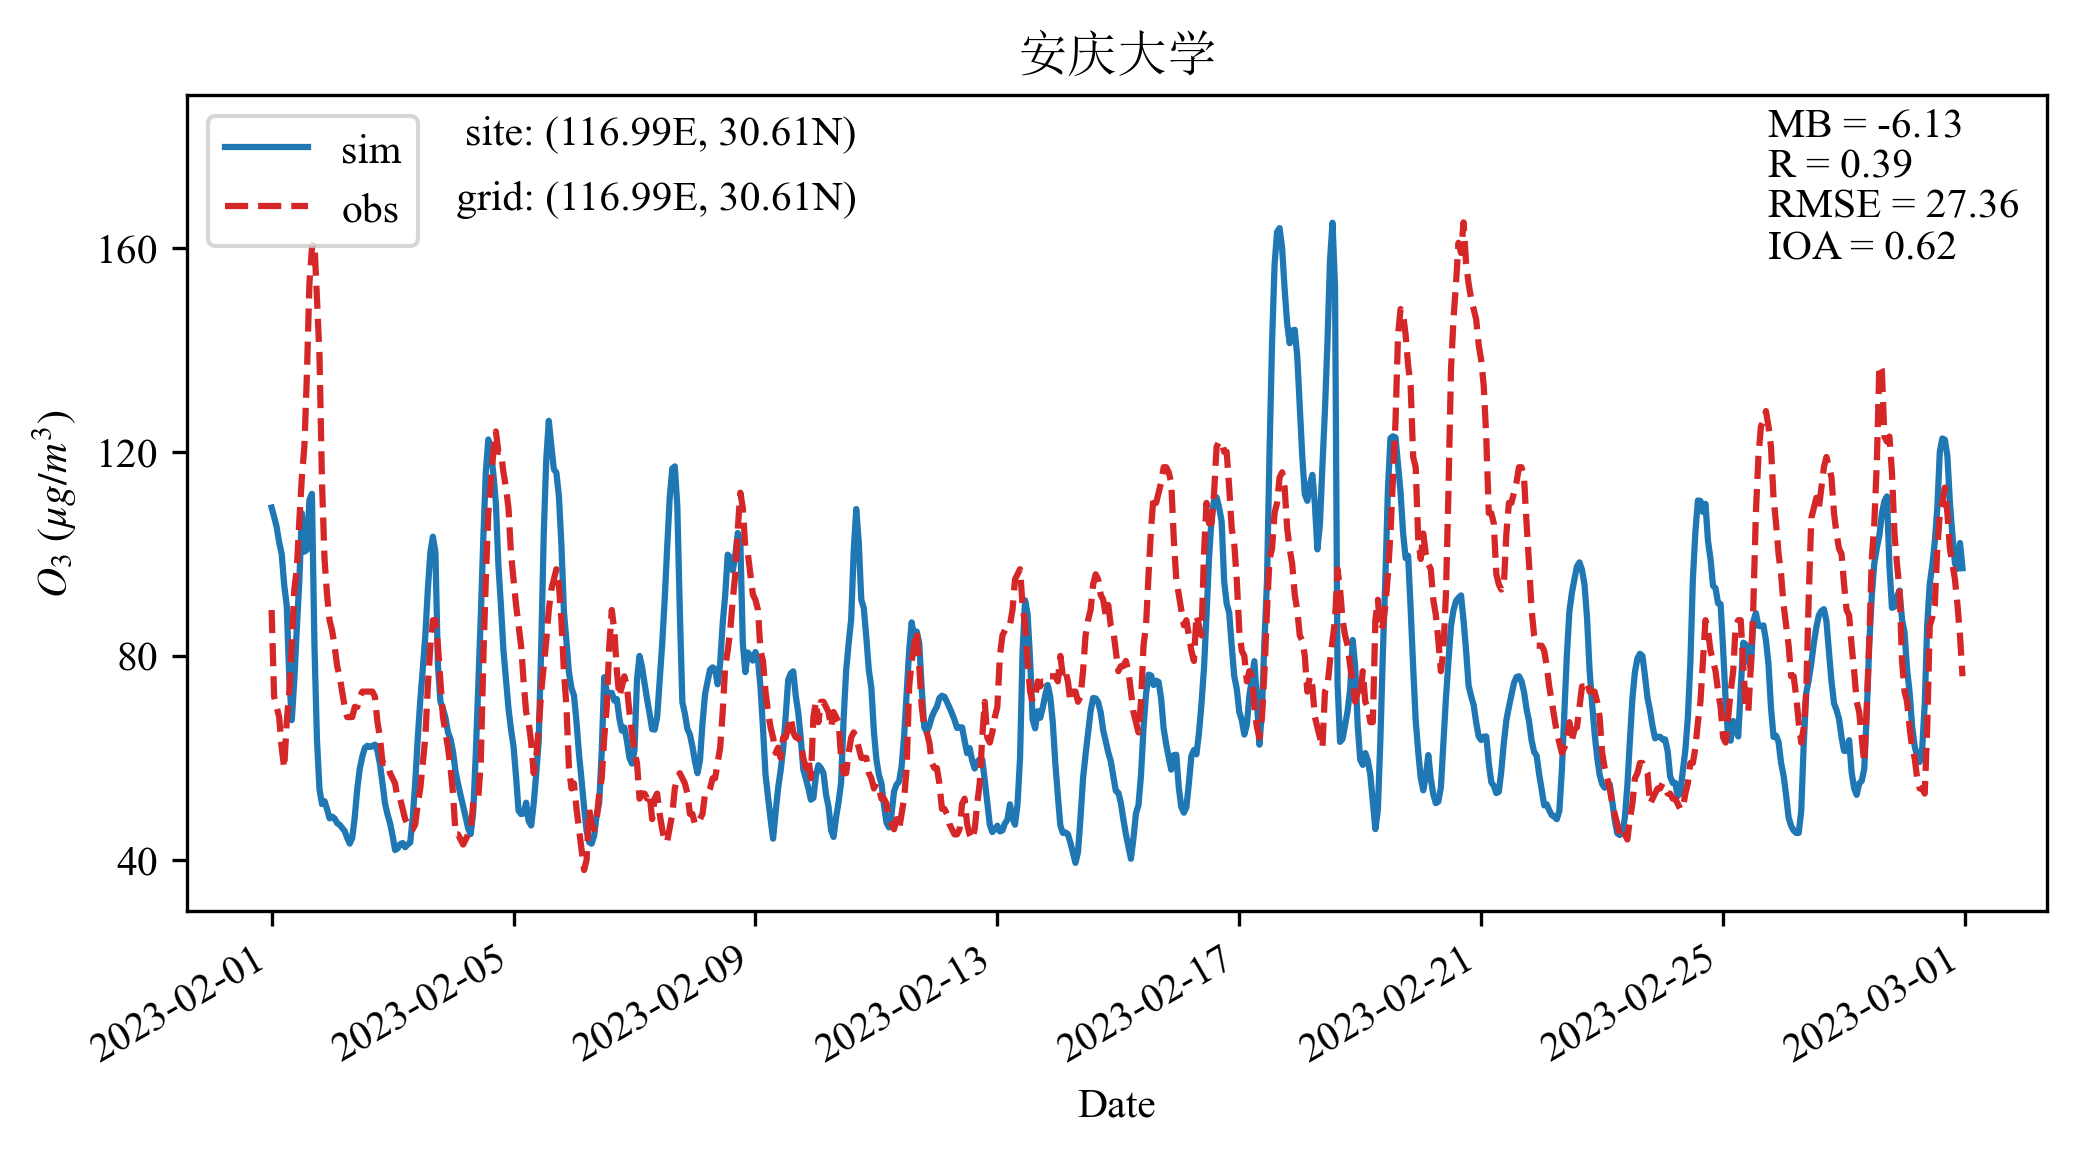

In [16]:
name = '安庆大学'
isite = 2

fig = plt.figure(figsize=(8,4),dpi=300)
ax = fig.subplots(1,1)

sim = nr[:,0,isite,isite]
obs = df[name]

sim.plot(ax=ax,linestyle='-',label='sim',color='tab:blue')
obs.plot(ax=ax,linestyle='--',label='obs',color='tab:red')

mb = np.array(np.mean(sim)-np.mean(obs))
r = pd.DataFrame({'A':sim,'B':obs}).corr().iloc[0,1]
rmse = me.cal_RMSE(obs,sim.data)
ioa = me.cal_IOA(obs,sim.data)

ax.text(x=0.85,y=0.95,s='MB = '+str(f"{mb:.2f}"),ha='left',transform=ax.transAxes)
ax.text(x=0.85,y=0.9,s='R = '+str(f"{r:.2f}"),ha='left',transform=ax.transAxes)
ax.text(x=0.85,y=0.85,s='RMSE = '+str(f"{rmse:.2f}"),ha='left',transform=ax.transAxes)
ax.text(x=0.85,y=0.8,s='IOA = '+str(f"{ioa:.2f}"),ha='left',transform=ax.transAxes)

ax.legend(loc=2)
ax.set_title(name,fontdict={'fontfamily':'SimSun'})
loctxt = 'site: ('+str(f"{lono[name]:.2f}")+'E, '+str(f"{lato[name]:.2f}")+'N)'
gridtxt = 'grid: ('+str(f"{sim.longitude.data:.2f}")+'E, '+str(f"{sim.latitude.data:.2f}")+'N)'
ax.text(x=0.36,y=0.94,s=loctxt,ha='right',transform=ax.transAxes)
ax.text(x=0.36,y=0.86,s=gridtxt,ha='right',transform=ax.transAxes)
ax.set_yticks(np.arange(0,161,40))
ax.set_ylim(30,190)
ax.set_ylabel('$O_3$ ($\mu$$g/m^3$)')
ax.set_xlabel('Date')

plt.show()

In [18]:
isite = 0
for name in sitename:
    fig = plt.figure(figsize=(8,4),dpi=300)
    ax = fig.subplots(1,1)
    sim = nr[:,0,isite,isite]
    obs = df[name]
    
    sim.plot(ax=ax,linestyle='-',label='sim',color='tab:blue')
    obs.plot(ax=ax,linestyle='--',label='obs',color='tab:red')
    
    mb = np.array(np.mean(sim)-np.mean(obs))
    r = pd.DataFrame({'A':sim,'B':obs}).corr().iloc[0,1]
    rmse = me.cal_RMSE(obs,sim.data)
    ioa = me.cal_IOA(obs,sim.data)
    
    ax.text(x=0.85,y=0.95,s='MB = '+str(f"{mb:.2f}"),ha='left',transform=ax.transAxes)
    ax.text(x=0.85,y=0.9,s='R = '+str(f"{r:.2f}"),ha='left',transform=ax.transAxes)
    ax.text(x=0.85,y=0.85,s='RMSE = '+str(f"{rmse:.2f}"),ha='left',transform=ax.transAxes)
    ax.text(x=0.85,y=0.8,s='IOA = '+str(f"{ioa:.2f}"),ha='left',transform=ax.transAxes)

    ax.legend(loc=2)
    ax.set_title(name,fontdict={'fontfamily':'SimSun'})
    loctxt = 'site: ('+str(f"{lono[name]:.2f}")+'E, '+str(f"{lato[name]:.2f}")+'N)'
    gridtxt = 'grid: ('+str(f"{sim.longitude.data:.2f}")+'E, '+str(f"{sim.latitude.data:.2f}")+'N)'
    ax.text(x=0.36,y=0.94,s=loctxt,ha='right',transform=ax.transAxes)
    ax.text(x=0.36,y=0.86,s=gridtxt,ha='right',transform=ax.transAxes)
    ax.set_yticks(np.arange(0,201,40))
    ax.set_ylabel('$O_3$ ($\mu$$g/m^3$)')
    ax.set_xlabel('Date')
    ax.set_ylim(20,200)
    
    path = 'F:/Data/case_anqing/figure/February/逐站点O3NO2/'
    plt.savefig(path+name+'.png')
    
    isite += 1